In [76]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
sql_llm = ChatGroq(model_name= "llama-3.1-70b-versatile")

In [77]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Float, TIMESTAMP 
from sqlalchemy.orm import sessionmaker, relationship, declarative_base
from langchain_core.runnables.config import RunnableConfig

load_dotenv()

True

In [78]:
DATABASE_URL = os.getenv("DATABASE_URL", "sqlite:///./db/hr.db")
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
SessionLocal

sessionmaker(class_='Session', autocommit=False, bind=Engine(sqlite:///./db/hr.db), autoflush=False, expire_on_commit=True)

In [79]:
import os
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sqlalchemy import text, inspect
from langgraph.graph import StateGraph, START, END

In [80]:
def get_database_schema(engine):
    inspector = inspect(engine)
    schema = ""
    for table_name in inspector.get_table_names():
        schema += f"Table: {table_name}\n"
        for column in inspector.get_columns(table_name):
            col_name = column["name"]
            col_type = str(column["type"])
            if column.get("primary_key"):
                col_type += ", Primary Key"
            if column.get("foreign_keys"):
                fk = list(column["foreign_keys"])[0]
                col_type += f", Foreign Key to {fk.column.table.name}.{fk.column.name}"
            schema += f"- {col_name}: {col_type}\n"
        schema += "\n"
    print("Retrieved database schema.")
    return schema

schema = get_database_schema(engine=engine)
print(schema)

Retrieved database schema.
Table: directors
- date: TIMESTAMP
- cnt_of_director: INTEGER
- avg_salary: INTEGER

Table: employees
- date: TIMESTAMP
- cnt_of_employees: INTEGER
- cnt_of_recruit: INTEGER
- cnt_of_retire: INTEGER
- cnt_of_talent: INTEGER




In [178]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question

    """
   
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool

GraphState

__main__.GraphState

In [179]:
class CheckRelevance(BaseModel):
    relevance: str = Field(
        description="Indicates whether the question is related to the database schema. 'relevant' or 'not_relevant'."
    )

def check_relevance(state: GraphState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Checking relevance of the question: {question}")
    system = """You are an assistant that determines whether a given question is related to the following database schema.

Schema:
{schema}

Respond with only "relevant" or "not_relevant".
""".format(schema=schema)
    human = f"Question: {question}"
    check_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", human),
        ]
    )
    llm = sql_llm
    structured_llm = llm.with_structured_output(CheckRelevance)
    relevance_checker = check_prompt | structured_llm
    relevance = relevance_checker.invoke({})
    state["relevance"] = relevance.relevance
    print(f"Relevance determined: {state['relevance']}")
    return state

# question = "2024년도에 직원 숫자가 가장 많았던 날짜들과 인원 숫자를 알려주세요."
question = "2024년에 직원수가 가장 많은 상위 3개의 날짜를 알려주세요"

GraphState = {"question": question, "attempts": 0}
GraphState
result = check_relevance(state=GraphState, config=None)
result


Retrieved database schema.
Checking relevance of the question: 2024년에 직원수가 가장 많은 상위 3개의 날짜를 알려주세요
Relevance determined: relevant


{'question': '2024년에 직원수가 가장 많은 상위 3개의 날짜를 알려주세요',
 'attempts': 0,
 'relevance': 'relevant'}

In [180]:
class ConvertToSQL(BaseModel):
    sql_query: str = Field(
        description="The SQL query corresponding to the natural language question."
    )

def convert_nl_to_sql(state: GraphState, config: RunnableConfig):
    question = state["question"]
    schema = get_database_schema(engine)
    print(f"Converting question to SQL : {question}")
    system = f"""You are an assistant that converts natural language questions into SQL queries based on the following schema:

{schema}

Provide only the SQL query without any explanations. 
Alias columns appropriately to match the expected keys in the result.

For example, alias 'food.name' as 'food_name' and 'food.price' as 'price'.
"""
    convert_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Question: {question}"),
        ]
    )
    llm = sql_llm
    structured_llm = llm.with_structured_output(ConvertToSQL)
    sql_generator = convert_prompt | structured_llm
    result = sql_generator.invoke({"question": question})
    state["sql_query"] = result.sql_query
    print(f">>> Generated SQL query: {state['sql_query']}")
    return state

result = convert_nl_to_sql(state=GraphState, config=None)
result

Retrieved database schema.
Converting question to SQL : 2024년에 직원수가 가장 많은 상위 3개의 날짜를 알려주세요
>>> Generated SQL query: SELECT date, cnt_of_employees AS cnt_of_employees FROM employees WHERE date LIKE '2024%' ORDER BY cnt_of_employees DESC LIMIT 3;


{'question': '2024년에 직원수가 가장 많은 상위 3개의 날짜를 알려주세요',
 'attempts': 0,
 'relevance': 'relevant',
 'sql_query': "SELECT date, cnt_of_employees AS cnt_of_employees FROM employees WHERE date LIKE '2024%' ORDER BY cnt_of_employees DESC LIMIT 3;"}

In [181]:
def execute_sql(state: GraphState):
    sql_query = state["sql_query"].strip()
    session = SessionLocal()
    print(f"Executing SQL query: {sql_query}")
    try:
        result = session.execute(text(sql_query))
        if sql_query.lower().startswith("select"):
            rows = result.fetchall()
            columns = result.keys()
            print(f">>> rows: {rows}")
            print(f">>> columns: {columns}")
            if rows:
                header = columns # ", ".join(columns)
                state["query_rows"] = [dict(zip(columns, row)) for row in rows]
                print(f"Raw SQL Query Result: {state['query_rows']}")





                # Format the result for readability
                data = rows[0]   ### 쿼리 결과의 탑 1번째 값만 취하는 경우가 아니라면, 문제가 있다.. (예컨데.. 상위 3개.. 이런식의 질문에 대응하지 못한다.)
                formatted_result = [f"{a}: {b}" for a, b in zip(header, data)]
                formatted_result = ", ".join(formatted_result)

                print(f">>> header: {header}")
                print(f">>> state_query_rows: {state["query_rows"]}")
                print(f">>> data1: {data}")
                data = [str(i) for i in data]
                data = ", ".join(data)
                print(f">>> data2: {data}")
                print(f">>> formatted_result: {formatted_result}")





            else:
                state["query_rows"] = []
                formatted_result = "No results found."
            state["query_result"] = formatted_result
            state["sql_error"] = False
            print("SQL SELECT query executed successfully.")
        else:
            session.commit()
            state["query_result"] = "The action has been successfully completed."
            state["sql_error"] = False
            print("SQL command executed successfully.")
    except Exception as e:
        state["query_result"] = f"Error executing SQL query: {str(e)}"
        state["sql_error"] = True
        print(f"Error executing SQL query: {str(e)}")
    finally:
        session.close()
    return state

result = execute_sql(state=GraphState)
result

Executing SQL query: SELECT date, cnt_of_employees AS cnt_of_employees FROM employees WHERE date LIKE '2024%' ORDER BY cnt_of_employees DESC LIMIT 3;
>>> rows: [('2024-06-27 00:00:00', 184), ('2024-06-26 00:00:00', 183), ('2024-06-24 00:00:00', 180)]
>>> columns: RMKeyView(['date', 'cnt_of_employees'])
Raw SQL Query Result: [{'date': '2024-06-27 00:00:00', 'cnt_of_employees': 184}, {'date': '2024-06-26 00:00:00', 'cnt_of_employees': 183}, {'date': '2024-06-24 00:00:00', 'cnt_of_employees': 180}]
>>> header: RMKeyView(['date', 'cnt_of_employees'])
>>> state_query_rows: [{'date': '2024-06-27 00:00:00', 'cnt_of_employees': 184}, {'date': '2024-06-26 00:00:00', 'cnt_of_employees': 183}, {'date': '2024-06-24 00:00:00', 'cnt_of_employees': 180}]
>>> data1: ('2024-06-27 00:00:00', 184)
>>> data2: 2024-06-27 00:00:00, 184
>>> formatted_result: date: 2024-06-27 00:00:00, cnt_of_employees: 184
SQL SELECT query executed successfully.


{'question': '2024년에 직원수가 가장 많은 상위 3개의 날짜를 알려주세요',
 'attempts': 0,
 'relevance': 'relevant',
 'sql_query': "SELECT date, cnt_of_employees AS cnt_of_employees FROM employees WHERE date LIKE '2024%' ORDER BY cnt_of_employees DESC LIMIT 3;",
 'query_rows': [{'date': '2024-06-27 00:00:00', 'cnt_of_employees': 184},
  {'date': '2024-06-26 00:00:00', 'cnt_of_employees': 183},
  {'date': '2024-06-24 00:00:00', 'cnt_of_employees': 180}],
 'query_result': 'date: 2024-06-27 00:00:00, cnt_of_employees: 184',
 'sql_error': False}

In [182]:
def generate_human_readable_answer(state: GraphState):

    sql = state["sql_query"]
    result = state["query_result"]
    query_rows = state.get("query_rows", [])
    sql_error = state.get("sql_error", False)

    print(f">>> sql: {sql}")
    print(f">>> result: {result}")
    print(f">>> query_rows: {query_rows}")
    print(f">>> sql_error: {sql_error}")

    print("Generating a human-readable answer.")
    system = f"""You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs. 
    """
    if sql_error:
        # Directly relay the error message
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable error message in a single sentence, informing them about the issue.

"""
                ),
            ]
        )
    elif sql.lower().startswith("select"):
        if not query_rows:
            # Handle cases with no orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, and mention that there are no orders found.
Generate the final answer in Korean(Han-gul)"""
                    ),
                ]
            )
        else:
            # Handle displaying orders
            generate_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable answer to the original question in a single sentence, and list each item ordered along with its numbers. 
For example: 'you have ordered Lasagne for $14.0 and Spaghetti Carbonara for $15.0.'
Generate the final answer in Korean(Han-gul)"""
                    ),
                ]
            )
    else:
        # Handle non-select queries
        generate_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"""SQL Query:
{sql}

Result:
{result}

Formulate a clear and understandable confirmation message in a single sentence, confirming that your request has been successfully processed.
Generate the final answer in Korean(Han-gul)"""
                ),
            ]
        )
    
    print(f">>> generate_prompt: {generate_prompt}")

    human_response = generate_prompt | sql_llm | StrOutputParser()
    answer = human_response.invoke({})
    state["query_result"] = answer
    print("Generated human-readable answer.")
    return state

result = generate_human_readable_answer(state=GraphState)
result

>>> sql: SELECT date, cnt_of_employees AS cnt_of_employees FROM employees WHERE date LIKE '2024%' ORDER BY cnt_of_employees DESC LIMIT 3;
>>> result: date: 2024-06-27 00:00:00, cnt_of_employees: 184
>>> query_rows: [{'date': '2024-06-27 00:00:00', 'cnt_of_employees': 184}, {'date': '2024-06-26 00:00:00', 'cnt_of_employees': 183}, {'date': '2024-06-24 00:00:00', 'cnt_of_employees': 180}]
>>> sql_error: False
Generating a human-readable answer.
>>> generate_prompt: input_variables=[] input_types={} partial_variables={} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are an assistant that converts SQL query results into clear, natural language responses without including any identifiers like order IDs. \n    '), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="SQL Query:\nSELECT date, cnt_of_employees AS cnt_of_emplo

{'question': '2024년에 직원수가 가장 많은 상위 3개의 날짜를 알려주세요',
 'attempts': 0,
 'relevance': 'relevant',
 'sql_query': "SELECT date, cnt_of_employees AS cnt_of_employees FROM employees WHERE date LIKE '2024%' ORDER BY cnt_of_employees DESC LIMIT 3;",
 'query_rows': [{'date': '2024-06-27 00:00:00', 'cnt_of_employees': 184},
  {'date': '2024-06-26 00:00:00', 'cnt_of_employees': 183},
  {'date': '2024-06-24 00:00:00', 'cnt_of_employees': 180}],
 'query_result': "2024년에 가장 많은 직원이 근무한 날은 2024-06-27이며, 그날 근무한 직원은 184명입니다.\n\n翻訳:\nTranslation: On the day with the most employees in 2024, which is 2024-06-27, there were 184 employees.\n\nHowever, considering the query is using LIMIT 3, it seems like the query is trying to get the top 3 dates with the most employees in 2024, but the result provided only shows one date. If we assume the result has more data, here's how you could formulate the answer:\n\n2024년에 가장 많은 직원이 근무한 날은 1. 2024-06-27에 근무한 직원 184명, 2. XXX에 근무한 직원 XXX명, 3. XXX에 근무한 직원 XXX명입니다.\n\nSince 

In [170]:
class RewrittenQuestion(BaseModel):
    question: str = Field(description="The rewritten question.")

def regenerate_query(state: GraphState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. 
    Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = sql_llm
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    # state = {"question": rewritten.question}
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state

result = regenerate_query(state=GraphState)
result

Regenerating the SQL query by rewriting the question.
Rewritten question: What are the dates in the year 2024 with the highest count of employees, and what is the corresponding number of employees on those dates, considering all the necessary table joins to retrieve complete and accurate data?


{'question': 'What are the dates in the year 2024 with the highest count of employees, and what is the corresponding number of employees on those dates, considering all the necessary table joins to retrieve complete and accurate data?',
 'attempts': 2,
 'relevance': 'relevant',
 'sql_query': "SELECT date, cnt_of_employees FROM employees WHERE STRFTIME('%Y', date) = '2024' ORDER BY cnt_of_employees DESC",
 'query_rows': [{'date': '2024-06-27 00:00:00', 'cnt_of_employees': 184},
  {'date': '2024-06-26 00:00:00', 'cnt_of_employees': 183},
  {'date': '2024-06-24 00:00:00', 'cnt_of_employees': 180},
  {'date': '2024-06-23 00:00:00', 'cnt_of_employees': 176},
  {'date': '2024-06-25 00:00:00', 'cnt_of_employees': 176},
  {'date': '2024-06-28 00:00:00', 'cnt_of_employees': 175},
  {'date': '2024-06-09 00:00:00', 'cnt_of_employees': 173},
  {'date': '2024-06-30 00:00:00', 'cnt_of_employees': 171},
  {'date': '2024-05-10 00:00:00', 'cnt_of_employees': 170},
  {'date': '2024-06-03 00:00:00', 'cnt

In [171]:
def relevance_router(state: GraphState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "no_relevance"

def execute_sql_router(state: GraphState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

def check_attempts_router(state: GraphState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

def end_max_iterations(state: GraphState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

In [172]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question

    """
   
    question: str
    sql_query: str
    query_result: str
    query_rows: list
    current_user: str
    attempts: int
    relevance: str
    sql_error: bool



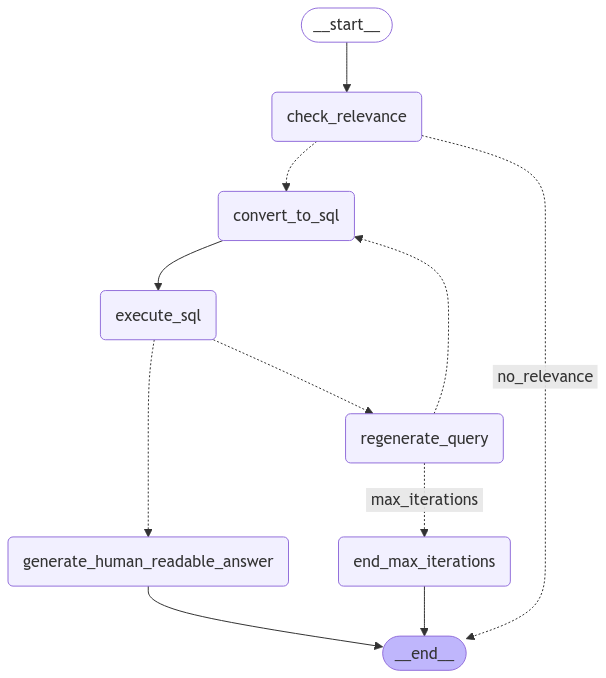

In [173]:

def sql_builder(state):
    sql_builder = StateGraph(state)
    sql_builder.add_node("check_relevance", check_relevance)
    sql_builder.add_node("convert_to_sql", convert_nl_to_sql)
    sql_builder.add_node("execute_sql", execute_sql)
    sql_builder.add_node("generate_human_readable_answer", generate_human_readable_answer)
    sql_builder.add_node("regenerate_query", regenerate_query)
    sql_builder.add_node("end_max_iterations", end_max_iterations)

    sql_builder.add_edge(START, "check_relevance")
    sql_builder.add_conditional_edges(
        "check_relevance",
        relevance_router,
        {
            "convert_to_sql": "convert_to_sql",
            "no_relevance": END,
        },
    )
    sql_builder.add_edge("convert_to_sql", "execute_sql")

    sql_builder.add_conditional_edges(
        "execute_sql",
        execute_sql_router,
        {
            "generate_human_readable_answer": "generate_human_readable_answer",
            "regenerate_query": "regenerate_query",
        },
    )

    sql_builder.add_conditional_edges(
        "regenerate_query",
        check_attempts_router,
        {
            "convert_to_sql": "convert_to_sql",
            "max_iterations": "end_max_iterations",
        },
    )

    sql_builder.add_edge("generate_human_readable_answer", END)
    sql_builder.add_edge("end_max_iterations", END)

    return sql_builder.compile()

graph = sql_builder(GraphState)

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(graph.get_graph().draw_mermaid_png()))

In [174]:
# question = "what is the average number of employees on March"
# question = "what is the average salary of directors on March 2024"
# question = "2024년 3월중 임원 급여가 가장 높은 날짜는?"
question = "2024년도에 직원 숫자가 가장 많았던 날짜와 인원수를 알려주세요 그리고 그 날짜의 퇴사자 인원도 알려주세요."
# question = "let me know the date that shows the highest salary of directors on March 2024"
# question = "which date showed the most salary of directors in 2024?"
# question = "compare the average number of employees on March and April. (which one is larger and the ratio, etc.)"

In [175]:
try:
    result_2 = graph.invoke({"question": question, "attempts": 0})
    print("Result:", result_2["query_result"])
except Exception as e:
    print(f"ERROR: {e}")

Retrieved database schema.
Checking relevance of the question: 2024년도에 직원 숫자가 가장 많았던 날짜와 인원수를 알려주세요 그리고 그 날짜의 퇴사자 인원도 알려주세요.
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL : 2024년도에 직원 숫자가 가장 많았던 날짜와 인원수를 알려주세요 그리고 그 날짜의 퇴사자 인원도 알려주세요.
>>> Generated SQL query: SELECT date AS date, cnt_of_employees AS max_cnt_of_employees, cnt_of_retire AS cnt_of_retire FROM employees WHERE date LIKE '2024%' AND cnt_of_employees = (SELECT MAX(cnt_of_employees) FROM employees WHERE date LIKE '2024%')
Executing SQL query: SELECT date AS date, cnt_of_employees AS max_cnt_of_employees, cnt_of_retire AS cnt_of_retire FROM employees WHERE date LIKE '2024%' AND cnt_of_employees = (SELECT MAX(cnt_of_employees) FROM employees WHERE date LIKE '2024%')
>>> rows: [('2024-06-27 00:00:00', 184, 4)]
>>> columns: RMKeyView(['date', 'max_cnt_of_employees', 'cnt_of_retire'])
Raw SQL Query Result: [{'date': '2024-06-27 00:00:00', 'max_cnt_of_employees': 184, 'cnt_of_retire': 4}]
>>> h

In [176]:
from langgraph.graph import StateGraph, START, END
from langgraph.errors import GraphRecursionError
# Run
def app_stream(graph, question:str, recursion_limit:int=10):
    inputs = {
        "question": question, 
        }
    config = {
        "recursion_limit": recursion_limit, 
        }
    try:
        for output in graph.stream(inputs, 
                                config, 
                                # stream_mode="debug"
                                ):
            for key, value in output.items():
                # Node
                print(f">>> Node : {key}")
            print("="*70)

        # Final generation
        print("")
    except GraphRecursionError:
        print(f"=== Recursion Error - {recursion_limit} ===")
        value = f"=== Recursion Error - {recursion_limit} ==="
    
    return value

In [177]:
try:
    result = app_stream(graph=graph, question=question, recursion_limit=5)
    print(result)
    print("")
    print(f">>> result_sql_query: {result['sql_query']}")
    print(f">>> result.query_result:{result['query_result']}")
    
except Exception as e:
    print(f"ERROR: {e}")


Retrieved database schema.
Checking relevance of the question: 2024년도에 직원 숫자가 가장 많았던 날짜와 인원수를 알려주세요 그리고 그 날짜의 퇴사자 인원도 알려주세요.
Relevance determined: relevant
>>> Node : check_relevance
Retrieved database schema.
Converting question to SQL : 2024년도에 직원 숫자가 가장 많았던 날짜와 인원수를 알려주세요 그리고 그 날짜의 퇴사자 인원도 알려주세요.
>>> Generated SQL query: SELECT date AS date, cnt_of_employees AS cnt_of_employees, cnt_of_retire AS cnt_of_retire FROM employees WHERE date LIKE '2024%' ORDER BY cnt_of_employees DESC LIMIT 1
>>> Node : convert_to_sql
Executing SQL query: SELECT date AS date, cnt_of_employees AS cnt_of_employees, cnt_of_retire AS cnt_of_retire FROM employees WHERE date LIKE '2024%' ORDER BY cnt_of_employees DESC LIMIT 1
>>> rows: [('2024-06-27 00:00:00', 184, 4)]
>>> columns: RMKeyView(['date', 'cnt_of_employees', 'cnt_of_retire'])
Raw SQL Query Result: [{'date': '2024-06-27 00:00:00', 'cnt_of_employees': 184, 'cnt_of_retire': 4}]
>>> header: RMKeyView(['date', 'cnt_of_employees', 'cnt_of_retire'])
>>> sta